In [ ]:
# Import libraries
# Import trained models
# Import Test dataset - Etoori and HiWiked
# Inference - Different types of errors

In [1]:
!nvidia-smi

Sat May 13 14:59:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.84       Driver Version: 460.84       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   23C    P8     8W / 250W |    447MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   

In [2]:
import os
import torch
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
n_gpu = torch.cuda.device_count()
print(n_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

4


'GeForce GTX 1080 Ti'

In [3]:
import os
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
#Importing Libraries
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
#import argparse
#import glob
#import os
#import json
import time
import logging
import random
#import re
#from itertools import chain
#from string import punctuation
#Set a seed
import random
import numpy as np
import torch
import datasets
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package punkt to /DATA/gupta92/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
from transformers import T5Tokenizer, MT5ForConditionalGeneration,AutoTokenizer,T5ForConditionalGeneration,EncoderDecoderModel
model_name_mT5_small = 'mT5_Etoori_2'
#model_name_T5_muRIL = 't5_gec_hindi_muRIL_best_Full'
model_name_T5_muRIL = 't5_gec_hindi_muRIL'
model_name_T5_RoBERTa = 't5_gec_hindi_Roberta'
model_name_bert_multilingual = 'hindi_EncDec_mbert'

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu' 

tokenizer_muRIL = AutoTokenizer.from_pretrained("google/muril-base-cased")
tokenizer_bert_multilingual = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
tokenizer_RoBERTa = AutoTokenizer.from_pretrained("surajp/RoBERTa-hindi-guj-san")

#trained_model_mT5_small = MT5ForConditionalGeneration.from_pretrained(model_name_mT5_small).to(torch_device)
trained_model_bert_multilingual = EncoderDecoderModel.from_pretrained(model_name_bert_multilingual).to(torch_device)
trained_model_T5_muRIL = T5ForConditionalGeneration.from_pretrained(model_name_T5_muRIL).to(torch_device)
trained_model_T5_RoBERTa = T5ForConditionalGeneration.from_pretrained(model_name_T5_RoBERTa).to(torch_device)


In [8]:
trained_model_mT5_small = MT5ForConditionalGeneration.from_pretrained(model_name_mT5_small).to(torch_device)

In [9]:
model_name_T5_muRIL_full = 't5_gec_hindi_muRIL_best_Full'
trained_model_T5_muRIL_full = T5ForConditionalGeneration.from_pretrained(model_name_T5_muRIL_full).to(torch_device)

In [45]:
def gec_prediction(incorrect,correct,tokenizer_name,model_name):
    l = len(correct)
    predicted_s = correct_grammar(incorrect,tokenizer_name,model_name,num_return_sequences=4)[0]
    p = len(predicted_s)
    if(p>l):
        predicted_s = predicted_s[:l]
    elif (p<l):
        pass
        #pass
    
    
    return predicted_s

In [11]:
def model_size_calculation(model_name):
    #Model Selection : mT5_small, encoder_decoder_bert-multilingual, T5_muRIL, T5_RoBERTa
    if(model_name =="mT5_small"):
        trained_model = trained_model_mT5_small
    elif (model_name =="encoder_decoder_bert-multilingual"):
        trained_model = trained_model_bert_multilingual
    elif (model_name =="T5_muRIL"):
        trained_model = trained_model_T5_muRIL
    elif (model_name =="T5_RoBERTa"):
        trained_model = trained_model_T5_RoBERTa
    elif (model_name =="T5_MuRIL_Full"):
        trained_model =    trained_model_T5_muRIL_full
    else:
        print("Incorrect model name")
        return
    param_size = 0
    for param in trained_model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in trained_model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    #print('model size: {:.3f}MB'.format(size_all_mb))
    return size_all_mb

In [12]:
#Model paremeters
from prettytable import PrettyTable

def count_model_parameters(model_name):
    #Model Selection : mT5_small, encoder_decoder_bert-multilingual, T5_muRIL, T5_RoBERTa
    if(model_name =="mT5_small"):
        trained_model = trained_model_mT5_small
    elif (model_name =="encoder_decoder_bert-multilingual"):
        trained_model = trained_model_bert_multilingual
    elif (model_name =="T5_muRIL"):
        trained_model = trained_model_T5_muRIL
    elif (model_name =="T5_RoBERTa"):
        trained_model = trained_model_T5_RoBERTa
    elif (model_name =="T5_MuRIL_Full"):
        trained_model =    trained_model_T5_muRIL_full
    else:
        print("Incorrect model name")
        return
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in trained_model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    #print(table)
    #print(f"Total Trainable Params: {total_params}")
    return table,total_params

#count_parameters(trained_model)


In [13]:
def correct_grammar(input_text,tokenizer_name,model_name,num_return_sequences):
    # Tokenizer Selection : MuRIL, bert-base-multilingual-cased, RoBERTa
    if(tokenizer_name =="MuRIL"):
        tokenizer = tokenizer_muRIL
    elif (tokenizer_name =="bert-base-multilingual-cased"):
        tokenizer = tokenizer_bert_multilingual
    elif (tokenizer_name =="RoBERTa"):
        tokenizer = tokenizer_RoBERTa
    else:
        print("Incorrect Tokenizer name")
        return
    
    #Model Selection : mT5_small, encoder_decoder_bert-multilingual, T5_muRIL, T5_RoBERTa
    if(model_name =="mT5_small"):
        trained_model = trained_model_mT5_small
    elif (model_name =="encoder_decoder_bert-multilingual"):
        trained_model = trained_model_bert_multilingual
    elif (model_name =="T5_muRIL"):
        trained_model = trained_model_T5_muRIL
    elif (model_name =="T5_RoBERTa"):
        trained_model = trained_model_T5_RoBERTa
    elif (model_name =="T5_MuRIL_Full"):
        trained_model =    trained_model_T5_muRIL_full
    else:
        print("Incorrect model name")
        return
        
    batch = tokenizer([input_text],truncation=True,padding='max_length',max_length=64, return_tensors="pt",return_token_type_ids=False).to(device)
    translated= trained_model.generate(**batch,max_length=64,num_beams=4, num_return_sequences=num_return_sequences, temperature=1.5)
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
    return tgt_text

# Test Dataset

In [14]:
#Test Dataset : 
#df_test_etoori, df_test_HiWikEd, df_test_pron_infl, df_test_adj_infl, df_test_adp_infl, df_test_verb_infl,df_test_noun_infl

df_test_etoori = pd.read_csv('DATA/etoori_test.csv')
df_test_etoori = df_test_etoori.head(10000)
print("Etoori Test dataset:", df_test_etoori.shape)

df_test_HiWikEd = pd.read_csv('DATA/HiWikEd.csv')
df_test_HiWikEd = df_test_HiWikEd.drop(['Unnamed: 0'], axis=1)
print("HiWikEd Full Test dataset:", df_test_HiWikEd.shape)

df_test_pron_infl = pd.read_csv('DATA/Wikiedits_PRON_INFL.csv')
print("PRON_INFL Test dataset:", df_test_pron_infl.shape)

df_test_adj_infl = pd.read_csv('DATA/Wikiedits_ADJ_INFL.csv')
print("ADJ_INFL Test dataset:", df_test_adj_infl.shape)

df_test_adp_infl = pd.read_csv('DATA/Wikiedits_ADP_INFL.csv')
print("ADP_INFL Test dataset:", df_test_adp_infl.shape)

df_test_verb_infl = pd.read_csv('DATA/Wikiedits_VERB_INFL.csv')
print("VERB_INFL Test dataset:", df_test_verb_infl.shape)

df_test_noun_infl = pd.read_csv('DATA/Wikiedits_NOUN_INFL.csv')
print("NOUN_INFL Test dataset:", df_test_noun_infl.shape)


Etoori Test dataset: (10000, 2)
HiWikEd Full Test dataset: (13187, 2)
PRON_INFL Test dataset: (496, 2)
ADJ_INFL Test dataset: (150, 2)
ADP_INFL Test dataset: (1101, 2)
VERB_INFL Test dataset: (5241, 2)
NOUN_INFL Test dataset: (182, 2)


In [11]:
# Model Selection : mT5_small, encoder_decoder_bert-multilingual, T5_muRIL, T5_RoBERTa,T5_MuRIL_Full
# model_size_calculation (trained_model)
# Tokenizer Selection : MuRIL, bert-base-multilingual-cased, RoBERTa


# Trained Model Size and Parameters

In [115]:
selected_model = "encoder_decoder_bert-multilingual"
msize = model_size_calculation(selected_model)
print('Size of trained model:',selected_model ,'= {:.3f} MB'.format(msize))
table,total_model_prams = count_model_parameters(selected_model)
print('Total Trainable Parameters of model:',selected_model , '=',total_model_prams)
print("___________________________________________________________________________")

selected_model = "T5_RoBERTa"
msize = model_size_calculation(selected_model)
print('Size of trained model:',selected_model ,'= {:.3f} MB'.format(msize))
table,total_model_prams = count_model_parameters(selected_model)
print('Total Trainable Parameters of model:',selected_model , '=',total_model_prams)
print("___________________________________________________________________________")

selected_model = "T5_muRIL"
msize = model_size_calculation(selected_model)
print('Size of trained model:',selected_model ,'= {:.3f} MB'.format(msize))
table,total_model_prams = count_model_parameters(selected_model)
print('Total Trainable Parameters of model:',selected_model , '=',total_model_prams)
print("___________________________________________________________________________")


selected_model = "T5_MuRIL_Full"
msize = model_size_calculation(selected_model)
print('Size of trained model:',selected_model ,'= {:.3f} MB'.format(msize))
table,total_model_prams = count_model_parameters(selected_model)
print('Total Trainable Parameters of model:',selected_model , '=',total_model_prams)
print("___________________________________________________________________________")

selected_model = "mT5_small"
msize = model_size_calculation(selected_model)
print('Size of trained model:',selected_model ,'= {:.3f} MB'.format(msize))
table,total_model_prams = count_model_parameters(selected_model)
print('Total Trainable Parameters of model:',selected_model , '=',total_model_prams)


Size of trained model: encoder_decoder_bert-multilingual = 1465.603 MB
Total Trainable Parameters of model: encoder_decoder_bert-multilingual = 384194811
___________________________________________________________________________
Size of trained model: T5_RoBERTa = 845.604 MB
Total Trainable Parameters of model: T5_RoBERTa = 221670144
___________________________________________________________________________
Size of trained model: T5_muRIL = 1334.168 MB
Total Trainable Parameters of model: T5_muRIL = 349744128
___________________________________________________________________________
Size of trained model: T5_MuRIL_Full = 1334.168 MB
Total Trainable Parameters of model: T5_MuRIL_Full = 349744128
___________________________________________________________________________
Size of trained model: mT5_small = 1145.083 MB
Total Trainable Parameters of model: mT5_small = 300176768


# Model Inference Time

In [132]:
text = df_test_etoori['enc_input'].iat[150]

In [ ]:
#Model Selection :  encoder_decoder_bert-multilingual, T5_muRIL, T5_RoBERTa,T5_MuRIL_Full,mT5_small
# model_size_calculation (trained_model)
# Tokenizer Selection : MuRIL, bert-base-multilingual-cased, RoBERTa

In [134]:
selected_tokenizer, selected_model = "bert-base-multilingual-cased", "encoder_decoder_bert-multilingual"

In [135]:
%%time
predicted_s = correct_grammar(text,selected_tokenizer,selected_model, num_return_sequences=1)[0]

CPU times: user 1.13 s, sys: 31.6 ms, total: 1.16 s
Wall time: 1.16 s


In [136]:
selected_tokenizer, selected_model = "RoBERTa", "T5_RoBERTa"

In [137]:
%%time
predicted_s = correct_grammar(text,selected_tokenizer,selected_model, num_return_sequences=1)[0]

CPU times: user 1.36 s, sys: 12.4 ms, total: 1.38 s
Wall time: 1.38 s


In [138]:
selected_tokenizer, selected_model = "MuRIL", "T5_muRIL"

In [139]:
%%time
predicted_s = correct_grammar(text,selected_tokenizer,selected_model, num_return_sequences=1)[0]

CPU times: user 1.44 s, sys: 27.9 ms, total: 1.47 s
Wall time: 1.47 s


In [140]:
selected_tokenizer, selected_model = "MuRIL", "mT5_small"

In [141]:
%%time
predicted_s = correct_grammar(text,selected_tokenizer,selected_model, num_return_sequences=1)[0]

CPU times: user 986 ms, sys: 36.1 ms, total: 1.02 s
Wall time: 1.02 s


# Train and Validation Loss

In [1]:
#Noted from the different experiments for loss plot 
'''
BERT(2): 
Train_loss =[0.052400,0.022100]
Valid_loss = [0.089137,0.224824]

T5_RoBERTa(7): 
Train_loss=[0.381000,0.242100,0.202700,0.177300,0.160700,0.149800,0.140300,0.130300,0.122600,0.117400,0.113800,0.107500,0.103100,0.100100,0.095900,0.093300,0.089000,0.087600]
Valid_loss=[0.231782,0.177866,0.154563,0.139493,0.129129,0.122364,0.115996,0.108200,0.103263,0.099770,0.095423,0.092649,0.090006,0.087868,0.087461,0.086824,0.083149,0.081173]
Steps = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000

MuRIL:

mT5(5):
Train_loss = [0.691400,0.604500,0.433100,0.276800,0.112500]
Valid_Loss = [0.497808,0.454815,0.329243,0.194706,0.095339]

T5_MuRIL(10):
Train_Loss = [0.524600,0.444900,0.391500,0.356900,0.348300]
Valid_Loss = [0.324090,0.240954,0.194559,0.176006,0.169690]
'''
print()

In [177]:
import matplotlib.pyplot as plt
def model_plot(x,y,y_label,title):
    plt.figure(figsize=(4, 4))
    plt.plot(x, y)
    plt.xlabel('epoch')
    plt.ylabel(y_label)
    plt.title(title)
    # function to show the plot
    plt.show()

In [231]:
bert_Train_loss =[0.052400,0.022100]
bert_Valid_loss = [0.089137,0.224824]
num_epoch = [i for i in range(1,len(bert_Train_loss)+1)]

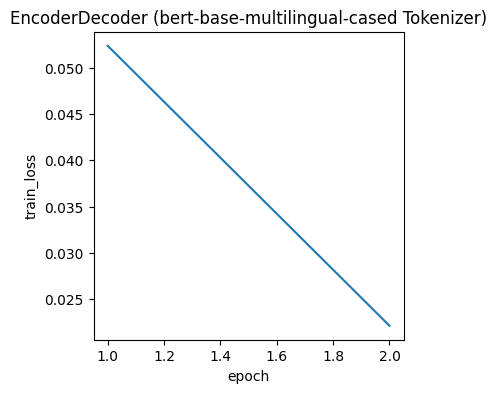

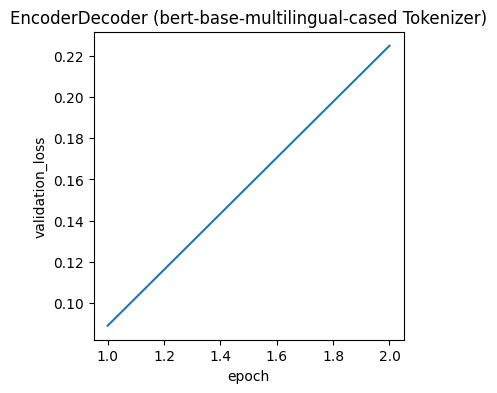

In [232]:
model_plot(num_epoch,bert_Train_loss,"train_loss","EncoderDecoder (bert-base-multilingual-cased Tokenizer)")
model_plot(num_epoch,bert_Valid_loss,"validation_loss","EncoderDecoder (bert-base-multilingual-cased Tokenizer)")


In [233]:
Train_loss=[0.381000,0.242100,0.202700,0.177300,0.160700,0.149800,0.140300,0.130300,0.122600,0.117400,0.113800,0.107500,0.103100,0.100100,0.095900,0.093300,0.089000,0.087600]
Valid_loss=[0.231782,0.177866,0.154563,0.139493,0.129129,0.122364,0.115996,0.108200,0.103263,0.099770,0.095423,0.092649,0.090006,0.087868,0.087461,0.086824,0.083149,0.081173]
Steps = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000]
print(len(Train_loss))
len(Steps)

18


18

In [235]:
import matplotlib.pyplot as plt
def model_plot1(x,y,y_label,title):
    plt.figure(figsize=(4, 4))
    #print(x,y)
    #print(len(x),len(y))
    plt.plot(x, y)
    plt.xlabel('steps')
    plt.ylabel(y_label)
    plt.title(title)
    # function to show the plot
    plt.show()

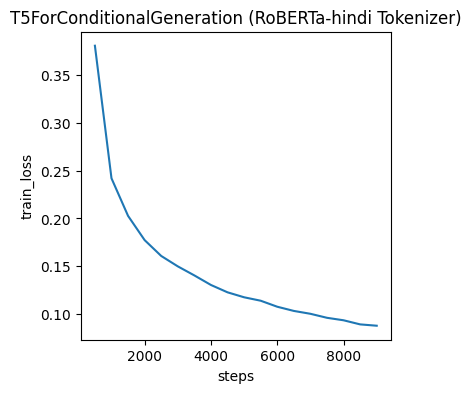

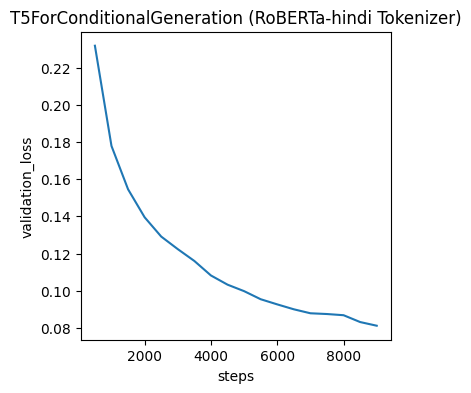

In [236]:
model_plot1(Steps,Train_loss,"train_loss","T5ForConditionalGeneration (RoBERTa-hindi Tokenizer)")
model_plot1(Steps,Valid_loss,"validation_loss","T5ForConditionalGeneration (RoBERTa-hindi Tokenizer)")


In [237]:
T5_Train_loss = [0.524600,0.444900,0.391500,0.356900,0.348300]
T5_Valid_Loss = [0.324090,0.240954,0.194559,0.176006,0.169690]
num_epoch = [6,7,8,9,10]

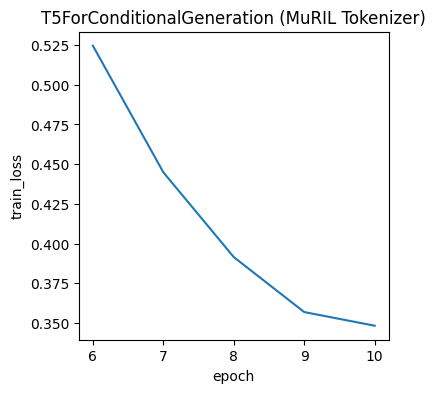

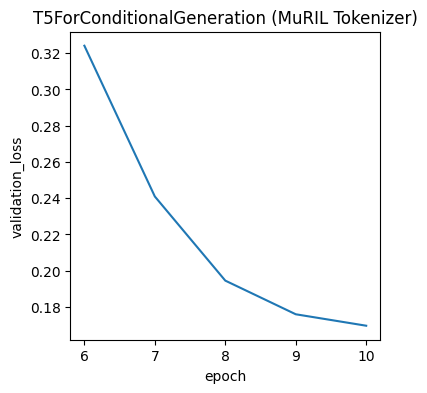

In [238]:
model_plot(num_epoch,T5_Train_loss,"train_loss","T5ForConditionalGeneration (MuRIL Tokenizer)")
model_plot(num_epoch,T5_Valid_Loss,"validation_loss","T5ForConditionalGeneration (MuRIL Tokenizer)")


In [239]:

mT5_Train_loss = [0.691400,0.604500,0.433100,0.276800,0.112500]
mT5_Valid_Loss = [0.497808,0.454815,0.329243,0.194706,0.095339]
num_epoch = [i for i in range(1,len(mT5_Train_loss)+1)]

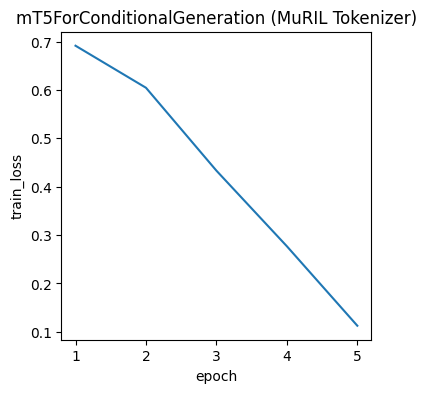

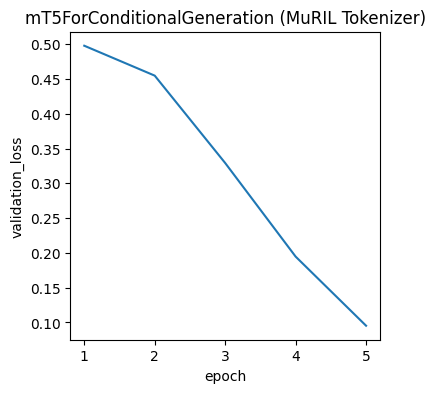

In [240]:
model_plot(num_epoch,mT5_Train_loss,"train_loss","mT5ForConditionalGeneration (MuRIL Tokenizer)")
model_plot(num_epoch,mT5_Valid_Loss,"validation_loss","mT5ForConditionalGeneration (MuRIL Tokenizer)")


# Etoori Test Dataset

In [44]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = 'मैं एम.टेक प्रोजेक्ट पर काम कर रही है|'
correct = 'मैं एम.टेक प्रोजेक्ट पर काम कर रही हूं|'
#correct=""
#text = 'उसनेीं बिपाशा ने यह स्वीकार किया है कि उन्हें कभी करीना को समझने का मौका ही नहीं मिला ।'
#correct = 'वहीं बिपाशा ने यह स्वीकार किया है कि उन्हें कभी करीना को समझने का मौका ही नहीं मिला ।'
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: मैं एम.टेक प्रोजेक्ट पर काम कर रही है|
Correct Seentence: मैं एम.टेक प्रोजेक्ट पर काम कर रही हूं|
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: मैं एम.टेक प्रोजेक्ट पर काम कर रही हूं|
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: मैं एम.टेक प्रोजेक्ट पर काम कर रही हूं|
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: मैं एम.टेक प्रोजेक्ट पर काम कर रही हूं|
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: मैं एम.टेक प्रोजेक्ट पर काम कर रही हूं|


In [31]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[9408]
correct = df_test_etoori['dec_input'].iat[9408]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: उसनेीं बिपाशा ने यह स्वीकार किया है कि उन्हें कभी करीना को समझने का मौका ही नहीं मिला ।
Correct Seentence: वहीं बिपाशा ने यह स्वीकार किया है कि उन्हें कभी करीना को समझने का मौका ही नहीं मिला । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: वहीं बिपाशा ने यह स्वीकार किया है कि उन्हें कभी करीना को समझने का मौका ही नहीं मिला । 
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: वहीं बिपाशा ने यह स्वीकार किया है कि उन्हें कभी करीना को समझने का मौका ही नहीं मिला । 
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: वहीं बिपाशा ने यह स्वीकार किया है कि उन्हें कभी करीना को समझने का मौका ही नहीं मिला । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: वहीं बिपाशा न

In [32]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[77]
correct = df_test_etoori['dec_input'].iat[77]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: सीआरपीएफ अप ट्रेनिंग में लड़कियों को आत्मरक्षा की पूरी जानकारी दी है ।
Correct Seentence: सीआरपीएफ ने अपने ट्रेनिंग में लड़कियों को आत्मरक्षा की पूरी जानकारी दी है । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: सीआरपीएफ ने अपने ट्रेनिंग में लड़कियों को आत्मरक्षा की पूरी जानकारी दी है । 
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: सीआरपीएफ ने अपने ट्रेनिंग में लड़कियों को आत्मरक्षा की पूरी जानकारी दी है । 
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: सीआरपीएफ ने अपने ट्रेनिंग में लड़कियों को आत्मरक्षा की पूरी जानकारी दी है । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: सीआरपीएफ ने अपने ट्रेनिंग में लड़कियों को आत्मरक्षा की पूरी जानकारी दी

In [241]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[50]
correct = df_test_etoori['dec_input'].iat[50]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: घर में घुस के बाद भी सुकून नहीं ।
Correct Seentence: घर में घुसने के बाद भी सुकून नहीं । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: घर में घुसने के बाद भी सुकून नहीं ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: घर में घुसने के बाद भी सुकून नहीं । 
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: घर में घुसने के बाद भी सुकून नहीं । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: घर में घुसने के बाद भी सुकून नहीं । 


In [47]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[6359]
correct = df_test_etoori['dec_input'].iat[6359]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: मैंने निर्णायक बन कर नहीं बैठता हूँ ।
Correct Seentence: मैं निर्णायक बन कर नहीं बैठता हूँ । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: मैं निर्णायक बन कर नहीं बैठता हूँ ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: मैं निर्णायक बन कर नहीं बैठता हूँ । 
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: मैं निर्णायक बन कर नहीं बैठता हूँ । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: मैं निर्णायक बन कर नहीं बैठता हूँ । 


In [46]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[501]
correct = df_test_etoori['dec_input'].iat[501]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: शहरी व ग्रामीण क्षेत्र में सीवरेज सिस्टम लागू कर का मुख्य उद्देश्य वातावरण को दूषित हो से बचाना है ।
Correct Seentence: शहरी व ग्रामीण क्षेत्र में सीवरेज सिस्टम लागू करने का मुख्य उद्देश्य वातावरण को दूषित होने से बचाना है । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: शहरी व ग्रामीण क्षेत्र में सीवरेज सिस्टम लागू करने का मुख्य उद्देश्य वातावरण को दूषित होने से बचाना है ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: शहरी व ग्रामीण क्षेत्र में सीवरेज सिस्टम लागू करने का मुख्य उद्देश्य वातावरण को दूषित
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: शहरी व ग्रामीण क्षेत्र में सीवरेज सिस्टम लागू करने का मुख्य उद्देश्य वातावरण को दूषित होने से बचाना है । 
___________________________________________________________________________
Selected Model:

In [60]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[185]
correct = df_test_etoori['dec_input'].iat[185]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: नानाजी देशमुख तो उनके दाएं हाथ थी ।
Correct Seentence: नानाजी देशमुख तो उनके दाएं हाथ थे । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: नानाजी देशमुख तो उनके दाएं हाथ थे ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: नानाजी देशमुख तो उनके दाएं हाथ थे । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: नानाजी देशमुख तो उनके दानेएं हाथ थे 


In [63]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[2]
correct = df_test_etoori['dec_input'].iat[2]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: आप पुस्तक पढ़ने में तल्लीन हैं और बच्चा उसनेाँ पर शोर मचा रहा है ।
Correct Seentence: आप पुस्तक पढ़ने में तल्लीन हैं और बच्चा वहाँ पर शोर मचा रहा है । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: आप पुस्तक पढ़ने में तल्लीन हैं और बच्चा वहाँ पर शोर मचा रहा है ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: आप पुस्तक पढ़ने में तल्लीन है और बच्चा वहाँ पर शोर मचा रहा है ।  
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: आप पुस्तक पढ़ने में तल्लीन हैं और बच्चा वहाँ पर शोर मचा रहा है । 


In [76]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[763]
correct = df_test_etoori['dec_input'].iat[763]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: वह बेटे की चाह कर रहे थी ।
Correct Seentence: वह बेटे की चाह कर रहे थे । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: वह बेटे की चाह कर रहे थे ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: वह बेटे की चाह कर रहे थे । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: वह बेटे की चाह कर रहे थे । 


In [77]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[863]
correct = df_test_etoori['dec_input'].iat[863]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: तब दार्जिलिंग की पहाड़ी वादियां उन्हें खूब लुभाती थें और वह अपने छोटे कदमों से पहाड़ नापने निकल पड़ती थें ।
Correct Seentence: तब दार्जिलिंग की पहाड़ी वादियां उन्हें खूब लुभाती थीं और वह अपने छोटे कदमों से पहाड़ नापने निकल पड़ती थीं । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: तब दार्जिलिंग की पहाड़ी वादियां उन्हें खूब लुभाती थीं और वह अपने छोटे कदमों से पहाड़ नापने निकल पड़ती थीं ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: तब दार्जिलिंग की पहाड़ी वादियां उन्हें खूब लुभाती थीं और उसने अपने छोटे कदमों से पहाड़ नापने निकल
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: तब दार्जिलिंग की पहाड़ी वादियां उन्हें खूब लुभाती थीं और वह अपने छोटे कदमों से पहाड़ नापने निकल पड़ती थीं । 


In [79]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[366]
correct = df_test_etoori['dec_input'].iat[366]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: आईआईटी के प्रश्नकर्ताओं की टीम आज इतनी लापरवाह हो चुकी है कि पिछले साल हिन्दी में पूछे गए प्रश्न ही अटपटे हो गए थी ।
Correct Seentence: आईआईटी के प्रश्नकर्ताओं की टीम आज इतनी लापरवाह हो चुकी है कि पिछले साल हिन्दी में पूछे गए प्रश्न ही अटपटे हो गए थे । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: आईआईटी के प्रश्नकर्ताओं की टीम आज इतनी लापरवाह हो चुकी है कि पिछले साल हिन्दी में पूछे गए प्रश्न ही अटपटे हो गए थे ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: आईआईटी के प्रश्नकर्ताओं की टीम आज इतनी लापरवाह हो चुकी है कि पिछले साल हिन्दी में पूछे गए प्रश्न
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: आईआईटी के प्रश्नकर्ताओं की टीम आज इतनी लापरवाह हो चुकी है कि पिछले साल हिन्दी में पूछे गए प्रश्न ही अटपटे हो गए थे । 


In [84]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[333]
correct = df_test_etoori['dec_input'].iat[333]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: उस महिला से साथ चल को कहा ।
Correct Seentence: उसने महिला से साथ चलने को कहा । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: उसने महिला से साथ चलने को कहा ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: उसने महिला से साथ चलने को कहा । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: उसने महिला से साथ चलने को कहा । 


In [86]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[111]
correct = df_test_etoori['dec_input'].iat[111]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: प्रारंभिक चेकअप के बाद चिकित्सकों उसे डेंगू संभावित केस करार दिया ।
Correct Seentence: प्रारंभिक चेकअप के बाद चिकित्सकों ने उसे डेंगू संभावित केस करार दिया । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: प्रारंभिक चेक नेअप के बाद चिकित्सकों उसे डेंगू संभावित केस करार दिया ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: प्रारंभिक चेकअप के बाद चिकित्सकों ने उसे डेंगू संभावित केस करार दिया । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: प्रारंभिक चेकअप के बाद चिकित्सकों ने उसे डेंगू संभावित केस करार दिया । 


In [101]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_etoori['enc_input'].iat[650]
correct = df_test_etoori['dec_input'].iat[650]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "RoBERTa"
selected_model = "T5_RoBERTa"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: उनका एक मक्सद थे अपनी अलग पहचान बनानेका और कायम रख़नेका ।
Correct Seentence: उनका एक मक्सद था अपनी अलग पहचान बनानेका और कायम रख़नेका । 
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: उनका एक मक्सद था अपनी अलग पहचान बनानेका और कायम रख़नेका ।
___________________________________________________________________________
Selected Model: T5_RoBERTa
Predicted Sentence: उनका एक मक्सद था अपनी अलग पहचान बनानेका और कायम रख़नेका । 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: उनका एक मक्सद था अपनी अलग पहचान बनानेका और कायम रख़नेका । 


In [68]:
#len("मैं इतनी अभिभूत थी कि उस वक्त सोच ही नही सकी कि लीला आखिर मुझ जैसी मामूली लडकी को इतना भाव क्य")

# HiWikEd Test Dataset

In [146]:
# Errors Types
#df_test_etoori, df_test_HiWikEd, df_test_pron_infl, df_test_adj_infl, df_test_adp_infl, df_test_verb_infl,df_test_noun_infl


In [155]:
#df_test_etoori, df_test_HiWikEd, df_test_pron_infl, df_test_adj_infl, df_test_adp_infl, df_test_verb_infl,df_test_noun_infl

selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_adp_infl['enc_input'].iat[111]
correct = df_test_adp_infl['dec_input'].iat[111]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "T5_MuRIL_Full"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: १९२७ में अखिल भारतीय हिंदी साहित्य सम्मलेन के अधिवेशन ने आपको " महामहोपाध्याय " के उपाधि से सम्मानित किया.
Correct Seentence: १९२७ में अखिल भारतीय हिंदी साहित्य सम्मलेन के अधिवेशन ने आपको " महामहोपाध्याय " की उपाधि से सम्मानित किया.
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: १९२७ में अखिल भारतीय हिंदी साहित्य सम्मलेन के अधिवेशन ने आपको " मेरठ " के उपाधि से सम्मानित किया.
___________________________________________________________________________
Selected Model: T5_MuRIL_Full
Predicted Sentence: १९२७ में अखिल भारतीय हिंदी साहित्य सम्मलेन के अधिवेशन ने आपको " महामहोपाध्याय " के उपाधि से सम्मानित किया.
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: तत में अखिल भारतीय हिंदी साहित्य सम्मलेन के अधिवेशन ने आपको उरुग्वे कोहिमा कोहिमा के उपाधि से सम्मानित किय
__________________________________________________________________

In [154]:
selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
text = df_test_adp_infl['enc_input'].iat[0]
correct = df_test_adp_infl['dec_input'].iat[0]
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "T5_MuRIL_Full"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: जल प्रदूषण पर नियंत्रण हेतु नालों का नियमित रूप से साफ सफाई करना चाहिए.
Correct Seentence: जल प्रदूषण पर नियंत्रण हेतु नालों की नियमित रूप से साफ सफाई करना चाहिए.
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: जल प्रदूषण पर नियंत्रण हेतु नालों का नियमित रूप से साफ सफाई करना चाहिए.
___________________________________________________________________________
Selected Model: T5_MuRIL_Full
Predicted Sentence: जल प्रदूषण पर नियंत्रण हेतु नालों का नियमित रूप से साफ सफाई करना चाहिए.
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: जल प्रदूषण पर नियंत्रण हेतु नालों का नियमित रूप से साफ सफाई करना चाहिए 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: जल प्रदूषण पर नियंत्रण हेतु नालों का नियमित रूप से साफ सफाई करना चाहिए 


In [158]:
#df_test_etoori, df_test_HiWikEd, df_test_pron_infl, df_test_adj_infl, df_test_adp_infl, df_test_verb_infl,df_test_noun_infl

text = df_test_HiWikEd['enc_input'].iat[111]
correct = df_test_HiWikEd['dec_input'].iat[111]

selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "T5_MuRIL_Full"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: राहुलजी को कृतियों की सूची बहुत लंबी है.
Correct Seentence: राहुलजी के कृतियों की सूची बहुत लंबी है.
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: राहुलजी को कृतियोंने की सूची बहुत लंबी ह
___________________________________________________________________________
Selected Model: T5_MuRIL_Full
Predicted Sentence: राहुलजी को कृतियों की सूची बहुत लंबी है.
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: राहुलजी को कृतियों की सूची ने बहुत लंबी 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: राहुलजी को कृतियों की सूची बहुत लंबी है 


In [160]:
#df_test_etoori, df_test_HiWikEd, df_test_pron_infl, df_test_adj_infl, df_test_adp_infl, df_test_verb_infl,df_test_noun_infl

text = df_test_pron_infl['enc_input'].iat[10]
correct = df_test_pron_infl['dec_input'].iat[10]

selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "T5_MuRIL_Full"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: इससे पहले वह बापतला लोक सभा क्षेत्र का प्रतिनिधित्व करती थीं.
Correct Seentence: इससे पहले वो बापतला लोक सभा क्षेत्र का प्रतिनिधित्व करती थीं.
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: इससे पहले वह बापतला लोक सभा क्षेत्र का प्रतिनिधित्व करती थीं.
___________________________________________________________________________
Selected Model: T5_MuRIL_Full
Predicted Sentence: इससे पहले वह बापतला लोक सभा क्षेत्र का प्रतिनिधित्व करती थीं.
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: इससे पहले उसने उरुग्वेला लोक सभा क्षेत्र का प्रतिनिधित्व करती
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: इससे पहले वह बापतला लोक सभा क्षेत्र का प्रतिनिधित्व करती थीं 


In [162]:
#df_test_etoori, df_test_HiWikEd, df_test_pron_infl, df_test_adj_infl, df_test_adp_infl, df_test_verb_infl,df_test_noun_infl

text = df_test_adj_infl['enc_input'].iat[100]
correct = df_test_adj_infl['dec_input'].iat[100]

selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "T5_MuRIL_Full"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: मेरी तकनीकी ज्ञान अच्छी है और यही मेरे प्रबंधन के आग्रह का मुख्य कारण है.
Correct Seentence: मेरा तकनीकी ज्ञान अच्छा है और यही मेरे प्रबंधन के आग्रह का मुख्य कारण है.
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: मेरा तकनीकी ज्ञान अच्छी है और यही मेरे प्रबंधन के आग्रह का मुख्य कारण है.
___________________________________________________________________________
Selected Model: T5_MuRIL_Full
Predicted Sentence: मेरी तकनीकी ज्ञान अच्छी है और यही मेरे प्रबंधन के आग्रह का मुख्य कारण है.
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: मेरा तकनीकी ज्ञान अच्छी है और यही मेरे प्रबंधन के आग्रह का मुख्य कारण है 
___________________________________________________________________________
Selected Model: encoder_decoder_bert-multilingual
Predicted Sentence: मेरी तकनीकी ज्ञान अच्छी है और यही मेरे प्रबंधन के आग्रह का मुख्य कारण है 


In [165]:
#df_test_etoori, df_test_HiWikEd, df_test_pron_infl, df_test_adj_infl, df_test_adp_infl, df_test_verb_infl,df_test_noun_infl

text = df_test_verb_infl['enc_input'].iat[50]
correct = df_test_verb_infl['dec_input'].iat[50]

selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "T5_MuRIL_Full"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: उनको बॉम्बे विश्वविद्यालय और रॉयल ऍन्थ्रोपोलोजिकल इंस्टीट्युट से इन्हे कई ऑनर्स प्राप्त हुए है.
Correct Seentence: उनको बॉम्बे विश्वविद्यालय और रॉयल ऍन्थ्रोपोलोजिकल इंस्टीट्युट से इन्हे कई ऑनर्स प्राप्त हुए हैं.
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: उनको बॉम्बे विश्वविद्यालय और रॉयल [unused3]्थ्रोपोलोजिकल इंस्टीट्युट से इन्हे कई ऑनर्स प्राप्त ह
___________________________________________________________________________
Selected Model: T5_MuRIL_Full
Predicted Sentence: उनको बॉम्बे विश्वविद्यालय और रॉयल धर्म्थ्रोपोलोजिकल इंस्टीट्युट से इन्हे कई शरीर्स प्राप्त हुए ह
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: उनको बॉम्बे विश्वविद्यालय और रॉयल तत्थ्रोपोलोजिकल इंस्टीट शादी से इन्हे कई ऑनर्स प्राप्त हुए हैं
___________________________________________________________________________
Selected Model: encoder_decoder_

In [166]:
#df_test_etoori, df_test_HiWikEd, df_test_pron_infl, df_test_adj_infl, df_test_adp_infl, df_test_verb_infl,df_test_noun_infl

text = df_test_noun_infl['enc_input'].iat[50]
correct = df_test_noun_infl['dec_input'].iat[50]

selected_tokenizer = "MuRIL"
selected_model = "T5_muRIL"
print("Incorrect Sentence:", text)
print("Correct Seentence:",correct)
print("___________________________________________________________________________")
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "T5_MuRIL_Full"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "MuRIL"
selected_model = "mT5_small"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

print("___________________________________________________________________________")
selected_tokenizer = "bert-base-multilingual-cased"
selected_model = "encoder_decoder_bert-multilingual"
print('Selected Model:',selected_model)
pred = gec_prediction(text,correct,selected_tokenizer,selected_model)
print("Predicted Sentence:",pred)

Incorrect Sentence: उन्होंने संस्कृत में आयुर्वेदिक औषधियों और जड़ी बूटी के ज्ञान में निपुणता प्राप्त की और इसका प्रचार प्रसार किया.
Correct Seentence: उन्होंने संस्कृत में आयुर्वेदिक औषधियों और जड़ी बूटियों के ज्ञान में निपुणता प्राप्त की और इसका प्रचार प्रसार किया.
___________________________________________________________________________
Selected Model: T5_muRIL
Predicted Sentence: उन्होंने संस्कृत में आयुर्वेदिक औषधियों और जड़ी बूटी के ज्ञान में निपुणता प्राप्त की और इसका प्रचार प्रसार किया.
___________________________________________________________________________
Selected Model: T5_MuRIL_Full
Predicted Sentence: उन्होंने संस्कृत में आयुर्वेदिक औषधियों और जड़ी के के ज्ञान में निपुणता प्राप्त की और इसका प्रचार प्रसार किया. के ज
___________________________________________________________________________
Selected Model: mT5_small
Predicted Sentence: उन्होंने संस्कृत में आयुर्वेदिक औषधियों और जड़ी बूटी के ज्ञान में निपुणता प्राप्त की और इसका प्रचार प्रसार किया कोह
__________________